<a href="https://colab.research.google.com/github/SmirnygaTotoshka/FBB_Courses/blob/main/%D0%A1%D0%B5%D0%BC%D0%B8%D0%BD%D0%B0%D1%80_2_%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B8_%D0%A5%D0%B5%D0%BC%D0%BE%D0%B8%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%82%D0%B8%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine learning

## Важность правильного разбиения для химических веществ

In [ ]:
import pandas as pd


Датасет [BACE](http://moleculenet.ai/datasets-1) загружен за вас, определены `X`, `y` и `smiles`.

In [ ]:
bace = pd.read_csv("./bace.csv", header=0)
bace.head(3)

FileNotFoundError: ignored

In [ ]:
X = bace.iloc[:,4:].values
y = bace["Class"].values
smiles = bace["mol"].values

**Разбейте X и y на тренировочную и тестовую выборки**, как в лекции. Соотношение train/test поставьте равным 3:1.\
*Подсказка*: воспользуйтесь функцией `train_test_split`.

**Осуществите стандартизацию признаков в выборке**.

**Импортируйте модель логистической регрессии и обучите ее на соответствующей части выборки (`model.fit`)**.

**Получите предсказание на оставшейся выборке**. Оцените его качество метриками из отчета о классификации (`classification_report`).

Функция `fingerprint_train_test_split`, приведенная ниже, осуществляет **разбиение train/test на основании молекулярных "отпечатков" (molecular fingerprints)**. Воспользуйтесь ей, чтобы получить **неслучайное разбиение на train/test** и повторите предыдущие шаги, чтобы оценить качество модели на таком случае.

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs

In [ ]:
def _split_fingerprints(fps, size1, size2):
    """This is called by fingerprint_train_test_split to divide a list of fingerprints into
    two groups.
    """
    assert len(fps) == size1 + size2

    # Begin by assigning the first molecule to the first group.

    fp_in_group = [[fps[0]], []]
    indices_in_group = ([0], [])
    remaining_fp = fps[1:]
    remaining_indices = list(range(1, len(fps)))
    max_similarity_to_group = [
        DataStructs.BulkTanimotoSimilarity(fps[0], remaining_fp),
        [0] * len(remaining_fp)
    ]
    while len(remaining_fp) > 0:
    # Decide which group to assign a molecule to.
        group = 0 if len(fp_in_group[0]) / size1 <= len(
            fp_in_group[1]) / size2 else 1

        # Identify the unassigned molecule that is least similar to everything in
        # the other group.

        i = np.argmin(max_similarity_to_group[1 - group])

        # Add it to the group.

        fp = remaining_fp[i]
        fp_in_group[group].append(fp)
        indices_in_group[group].append(remaining_indices[i])

        # Update the data on unassigned molecules.

        similarity = DataStructs.BulkTanimotoSimilarity(fp, remaining_fp)
        max_similarity_to_group[group] = np.delete(
            np.maximum(similarity, max_similarity_to_group[group]), i)
        max_similarity_to_group[1 - group] = np.delete(
            max_similarity_to_group[1 - group], i)
        del remaining_fp[i]
        del remaining_indices[i]
    return indices_in_group

In [ ]:
def fingerprint_train_test_split(X, y, smiles, test_size=0.1):
    assert X.shape[0] == y.shape[0] == smiles.shape[0]
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    fps = [AllChem.GetMorganFingerprintAsBitVect(x, 2, 1024) for x in mols]

    # Split into two groups: training set and everything else.

    test_size = int(test_size * len(y))
    train_size = len(y) - test_size
    train_inds, test_inds = _split_fingerprints(fps, train_size, test_size)
    
    X_train = X[train_inds,:]
    X_test = X[test_inds,:]
    y_train = y[train_inds]
    y_test = y[test_inds]
    
    return X_train, X_test, y_train, y_test

**Сделайте выводы**.

# AlphaFold2 

Ну и, наконец, AlphaFold2. 

Воспользуемся ноутбуком, выложенным в публичный доступ Сергеем Овчинниковым - [ссылка](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb)

В этом ноутбуке все полностью автоматизировано 

## Победы AlphaFold2

Не включайте template search, иначе совсем нечестно

In [ ]:
seq1 = "TTYKLILNLKQAKEEAIKELVDAGTAEKYIKLIANAKTVEGVWTLKDEIKTFTVTE"
seq2 = "TTYKLILNLKQAKEEAIKEAVDAGTAEKYFKLIANAKTVEGVWTYKDEIKTFTVTE"

In [ ]:
for ind, (s1, s2) in enumerate(zip(seq1, seq2) ):
  if s1 != s2:
    print(f"Differ: {s1}{ind}{s2}")

Differ: L19A
Differ: I29F
Differ: L44Y


Должно получиться как в [этой статье](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2779201/)

Конечно, можно заметить, что при обучении модель видела структуры, выложенные в PDB. Но у AlphaFold бывают успехи и на структурах, которые еще не были опубликованы и при этом сложны. 

## Поражения AlphaFold2

Промоделируйте следующую последовательность: 



In [ ]:
seq = '''MDQNNSLPPYAQGLASPQGAMTPGIPIFSPMMPYGTGLTPQPIQNTNSLSILEEQQRQQQ
QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQAVAAAAVQQSTSQQATQGTSGQAPQ
LFHSQTLTTAPLPGTTPLYPSPMTPMTPITPATPASESSGIVPQLQNIVSTVNLGCKLDL
KTIALRARNAEYNPKRFAAVIMRIREPRTTALIFSSGKMVCTGAKSEEQSRLAARKYARV
VQKLGFPAKFLDFKIQNMVGSCDVKFPIRLEGLVLTHQQFSSYEPELFPGLIYRMIKPRI
VLLIFVSGKVVLTGAKVRAEIYEAFENIYPILKGFRKTT'''

Сравните с тем, что [должно](https://twitter.com/PappulabWashU/status/1418332465740066816/photo/2) получиться 

## Click-chemistry 


In [ ]:
!pip install rdkit-pypi

In [ ]:
from IPython.display import display,Image

Популярная реакция в клик-химии это азид-алкиновое циклоприсоединение.


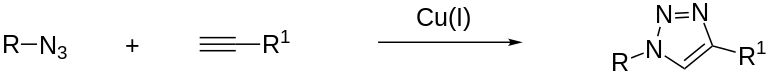

In [ ]:

display(Image('https://upload.wikimedia.org/wikipedia/commons/thumb/6/66/CuAAC.svg/768px-CuAAC.svg.png'))

Модицифируем наш ибупрофен таким образом, чтобы с ним было можно делать клик-химию

In [ ]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

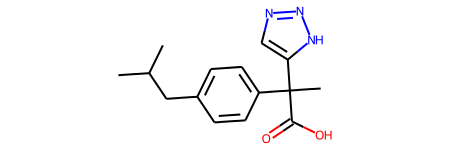

In [ ]:
mod_ibu=Chem.MolFromSmiles('CC(C)CC1=CC=C(C(C#C)=C1)C(C)C(=O)O')
AllChem.Compute2DCoords(mod_ibu)
display(al_ibu)

А теперь представим, что кликхимия произошла, и за N-N-N - другая молекула 

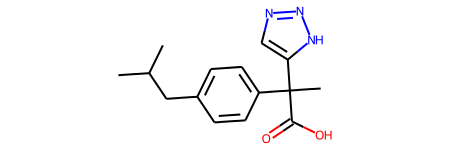

In [ ]:
al_ibu=Chem.MolFromSmiles('CC(C)CC1=CC=C(C=C1)C(C1=CN=NN1)(C)C(=O)O')
AllChem.Compute2DCoords(al_ibu)
display(al_ibu)

И перерисуем

In [ ]:
template = 'N1N=NC(=C1)C(C)(C(=O)O)C1=CC=C(C=C1)CC(C)C'
template_mol = Chem.MolFromSmiles(template)
AllChem.Compute2DCoords(template_mol)
display(template_mol)

Зачем? Чтобы потом просто заменять в молекуле азид на наш "ибупрофен"

Теперь нам надо скачать соединения из PubChem, содержащие азид

In [ ]:
!pip install pubchempy

In [ ]:

import pubchempy as pcp

Скачаем 100000 азидов (можно и больше, но их там больше миллиона включая стереоизомеры. Устанем)

In [ ]:
samples = 10000
steps = 10
smiles = "N=[N+]=[N-]"
azides = []

for step in range(steps):
  print(f"Step {step}")
  cur_azides = pcp.get_properties(properties="CanonicalSMILES", 
                            identifier=smiles, 
                            namespace="smiles", 
                            searchtype="substructure",
                            RingsNotEmbedded=False,
                            listkey_count=samples,
                            listkey_start= step * samples )
  azides.extend(cur_azides)

Берем только smiles 

In [ ]:
azides_smiles = [x['CanonicalSMILES'] for x in azides]
azides_smiles[:10]

Поиск в PubChem увлекателен. Давайте проверим, везде ли в найденных веществах есть азид

In [ ]:
azides_smiles[0:10]

NameError: ignored

In [ ]:
for smi in azides_smiles:
    
  # CODE HERE
  # check if "N=[N+]=[N-]" in smi. If not - break from cycle

print(smi)
Chem.MolFromSmiles(smi)

Потому придется фильтровать наш список от "незваных" молекул

Кроме того, можно грубо прикинуть, сколько максимально тяжелых атомов мы можем иметь в молекуле, чтобы она соответствовала правилу Липински

In [ ]:
500 /12

41.666666666666664

Потому все smiles бОльшей длины выкинем

In [ ]:
filtered_azides = [x for x in azides_smiles if ##len(x) <= and ]

In [ ]:
len(filtered_azides)

Жить стало легче, жить стало веселее. 

Отстается "провести" click-chemistry

In [ ]:
new_compounds = {}
for az in filtered_azides:
    product = az.replace("N=[N+]=[N-]", template)
    product_mol =  Chem.MolFromSmiles(product)
    new_compounds[product] = product_mol

В паре мест что-то сломалось(( 
Как это проявляется?

In [ ]:
for value in new_compounds.values():
    print(type(value))
    break
 mol = value

In [ ]:
for value in new_compounds.values():
    if type(mol) != type(value):
        print(value)
        break
 

In [ ]:
# try to find non=trivial values in output

Поправим наш код

In [ ]:
new_compounds = {}
for az in filtered_azides:
    product = az.replace("N=[N+]=[N-]", template)
    product_mol =  Chem.MolFromSmiles(product)
    
    #YOUR CODE IS HERE
    if product_mol is not None:
      new_compounds[product] = product_mol

Отлично, осталось проверить молекулы на соответствие правилу Липински

In [ ]:
lipinsi_ok = {smi: mol for smi, mol in new_compounds.items() if is_lipinsky(mol)}

In [ ]:
len(lipinsi_ok)

Много их нашлось. Возьмем первые 64

In [ ]:
from itertools import islice
mols = list(islice(lipinsi_ok.values(), 64))

In [ ]:
Draw.MolsToGridImage(mols, molsPerRow=8, subImgSize=(150, 150))

Посчитаем сходство какой-нить из сгенерированных молекул с исходной

In [ ]:
from rdkit.Chem.Draw import SimilarityMaps
similarity = SimilarityMaps.GetSimilarityMapForFingerprint(ibu, mols[2], SimilarityMaps.GetMorganFingerprint)

In [ ]:
similarity[1]

Маленькая 

Посмотрим на молекулу в 3d

In [ ]:
mol = mols[0]

m3d = Chem.AddHs(mol)
Chem.AllChem.EmbedMolecule(m3d)
AllChem.MMFFOptimizeMolecule(m3d, maxIters=500, nonBondedThresh=200)
display(m3d)

## Токсичность

У нас очень много веществ кандидатов. Хотелось бы как-то сузить список. 
Сделаем очень простое машинное обучение. 

In [ ]:
!pip install deepchem

Загрузим при помощи пакета deepchem себе датасет токсичности и каждую молекулу охарактеризуем фингерпринтом

In [ ]:
import deepchem as dc
tasks, datasets, transformers = dc.molnet.load_clintox(featurizer='ECFP', splitter="random")
train_dataset, valid_dataset, test_dataset = datasets

Будем учиться отличать токсичные вещества от нетоксичных

Загрузим простую логистическую регрессию 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

Запускать ее будет с параметрами по-умолчанию, потому валидационный датасет нам не понадобится, сольем его с обучающим

In [ ]:
train_X = np.concatenate([train_dataset.X, valid_dataset.X])
train_Y = np.concatenate([train_dataset.y[:, 1], valid_dataset.y[:, 1]])

Качество нашей модели неплохое

In [ ]:
model = LogisticRegression(penalty="l2")
### YOUR CODE HERE
print(roc_auc_score(y_score=model.predict_proba(test_dataset.X)[:, 1], y_true=test_dataset.y[:, 1]))

Попробуем для наших сгеенерированных веществ предсказать токсичность

In [ ]:
featurizer = dc.molnet.featurizers['ecfp']

In [ ]:
?featurizer

In [ ]:
mols = featurizer.featurize(list(lipinsi_ok.values()))

In [ ]:
is_toxic = model.predict(mols)

In [ ]:
is_toxic.mean()

Видим, что 33% молекул в наших 9000 - токсичны. И можем их выкинуть

Интересно, а токсична ли первая сгенерированная молекула по мнению модели?

In [ ]:
is_toxic[0]

In [ ]:
flat_list = set(x for sublist in lipinsi_ok.keys() for x in sublist)

In [ ]:
flat_list